# Testing AG Coordinate -- with biharmonic smoothing

This notebook evaluates the performance of the AG coordinate using a single density slice snapshot from the ANU-tub configuration. The AG coordinate is calculated using Angus' `pyale` package - these calculations are done within the notebook - see also `AG_VertRegrid.py` and `Evaluate_AG_Coord.ipynb` for a more thorough evaluation.

The `pyale` code is fortran-based, and pretty slow, so best to enable OpenMP to use multi-threading. Note that the cell below needs to be in the environment *before* OpenMP is initialised, which happens when you import the `pyale` module. Ideal is to match the number of threads with the number of cores available.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(28)

Import precompiled `pyale` code - note that you will need to match the python version here, or recompile to a newer version of python if that fails.

In [2]:
import toml
import sys
sys.path = ["/g/data/x77/ahg157/python-ale/build-biharmonic/lib.linux-x86_64-cpython-310"] + sys.path
import pyale

Import other standard plotting stuff.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

## Load grid information into dataset

This just uses a random restart file copied locally.

In [4]:
restart_filename = '/g/data/x77/amh157/anu-tub/diagnostics/INPUTS/MOM.res.nc'

In [5]:
ds2 = xr.open_dataset(restart_filename)

0.3.0


Text(0.5, 1.0, 'Temperature')

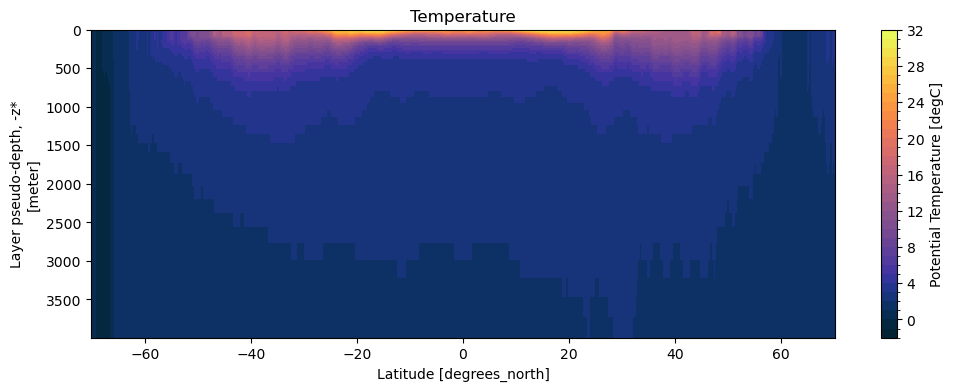

In [6]:
vlev = np.linspace(-2,32,35)
plt.figure(figsize=(12,4))
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()
plt.title('Temperature')

## Plotting function


In [7]:
def tpplot(field,h,vlev=50,cmap=cm.cm.thermal,title=''):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.subplot(212)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    plt.subplots_adjust(hspace=0)
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)
    return

def diagplot(diags):
    plt.figure(figsize=(14,6))
    diag_density = xr.DataArray(data=np.transpose(diags['adapt_disp_density'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))   

    plt.subplot(221)
    p1 = diag_density.plot(y = "depth")
    plt.gca().invert_yaxis()
    plt.title('adapt_disp_density')

    diag_smoothing = xr.DataArray(data=np.transpose(diags['adapt_disp_smoothing'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
    plt.subplot(222)
    p1 = diag_smoothing.plot(y = "depth")
    plt.gca().invert_yaxis()
    plt.title('adapt_disp_smoothing')

    diag_unlimited = xr.DataArray(data=np.transpose(diags['adapt_disp_unlimited'][43,3:-4,:-1]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
    plt.subplot(223)
    p1 = diag_unlimited.plot(y = "depth")
    plt.gca().invert_yaxis()
    plt.title('adapt_disp_unlimited')

    diag_total = diag_density + diag_smoothing + diag_unlimited 
    plt.subplot(224)
    p1 = diag_total.plot(y = "depth")
    plt.gca().invert_yaxis()
    plt.title('total')

    plt.figure(figsize=(14,4))

    plt.subplot(131)
    plt.plot(diag_total.yh[150:350],temp[39,150:350,48])
    plt.title('temp')

    ax = plt.subplot(132)
    ax.plot(diag_total.yh[150:350],h_depth[150:350,48],label='h')
    plt.legend()
    ax2=ax.twinx()
    diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(ax=ax2,color='r',label='total')
    plt.legend(loc=4)

    plt.subplot(133)
    diag_density.isel(zl=48).isel(yh=slice(150,350)).plot(label='density')
    diag_unlimited.isel(zl=48).isel(yh=slice(150,350)).plot(label='unlimited')
    diag_smoothing.isel(zl=48).isel(yh=slice(150,350)).plot(label='smoothing')
    diag_total.isel(zl=48).isel(yh=slice(150,350)).plot(label='total')
    plt.legend()
    return


## Do base case with standard parameters
This function reads in the parameters from the default `.toml` file, and sets up the function. Note that we have optimised default parameters and specify updated parameters manually -- see `Evaluate_AG_Coord.ipynb` for details. 

In [8]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt-biharmonic.toml")
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [9]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [ ]:
state_def = pyale.accelerate_ale(cs, adapt_cs, iter=1, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

h=state_def[0]
temp=state_def[1]
salt=state_def[2]
diags = state_def[3]


In [ ]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Default Parameters')

diagplot(diags)

## Turn off smoothing min

In [12]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_SMOOTH_MIN"] = 0.0                      # default is 0.1
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [13]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [14]:
state_sm0 = pyale.accelerate_ale(cs, adapt_cs, iter=500, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

h=state_sm0[0]
temp=state_sm0[1]
salt=state_sm0[2]
diags = state_sm0[3]


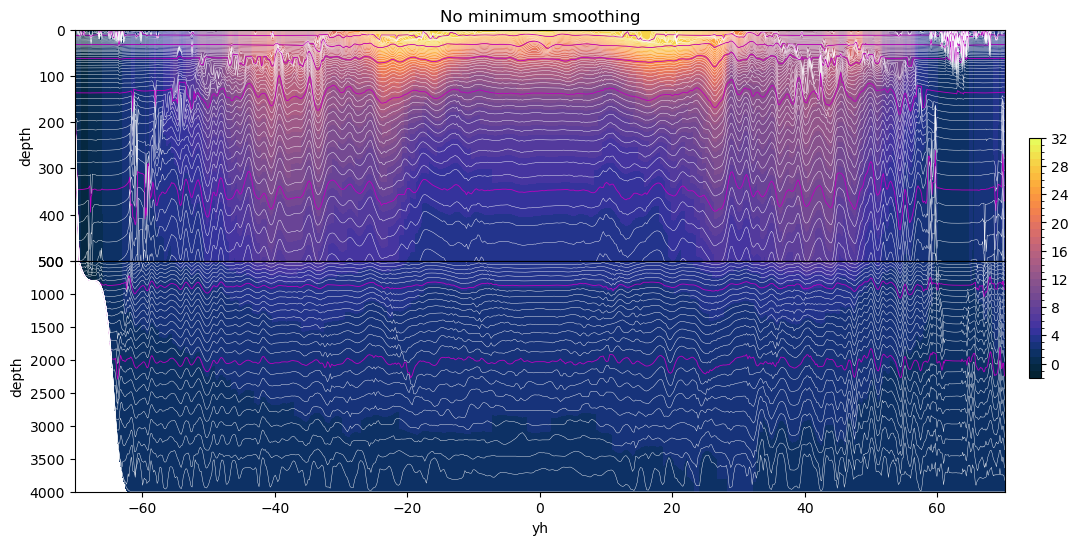

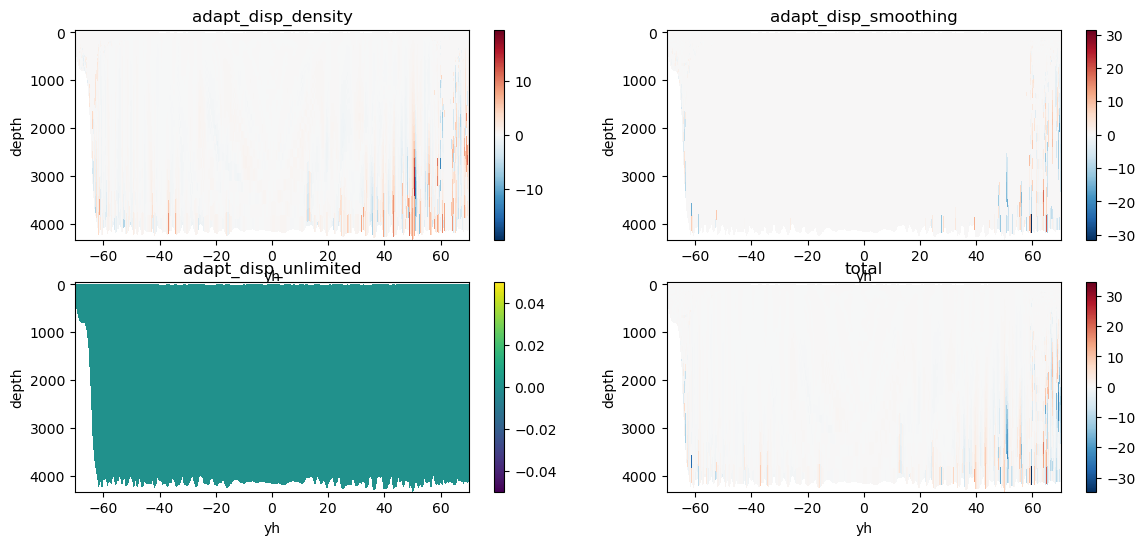

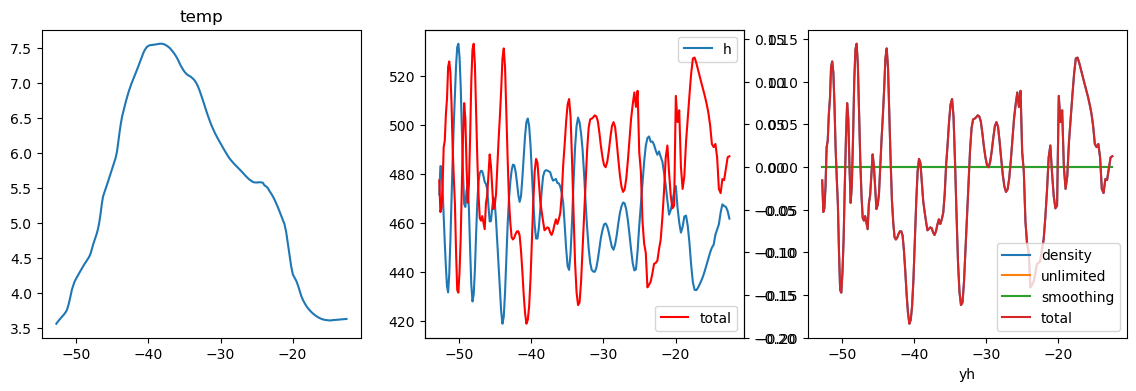

In [15]:

h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='No minimum smoothing')

diagplot(diags)


## Crank up smooth_min

In [16]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_SMOOTH_MIN"] = 0.2                      # default is 0.1
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [17]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [18]:
state_sm2 = pyale.accelerate_ale(cs, adapt_cs, iter=500, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

h=state_sm2[0]
temp=state_sm2[1]
salt=state_sm2[2]
diags = state_sm2[3]

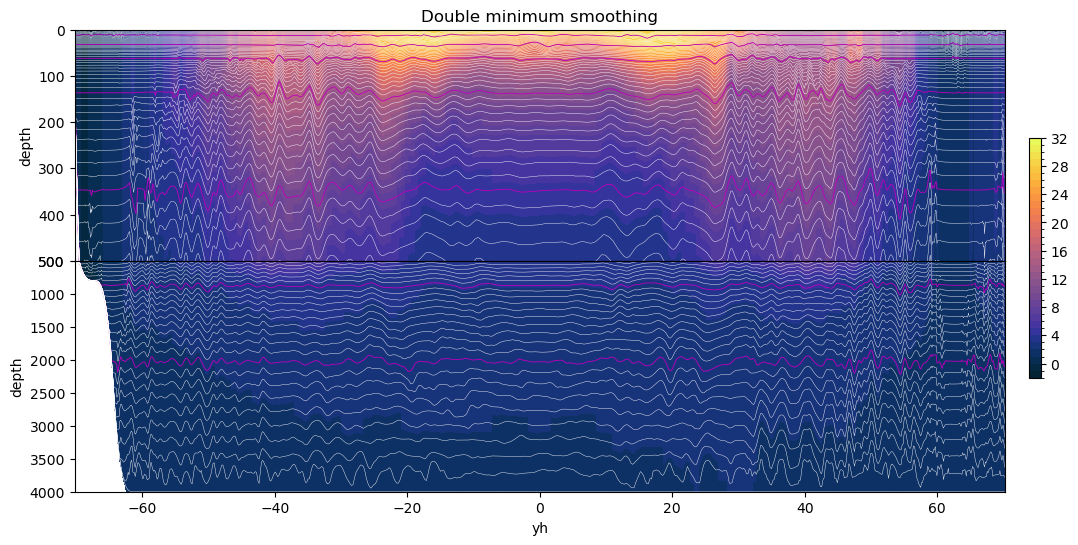

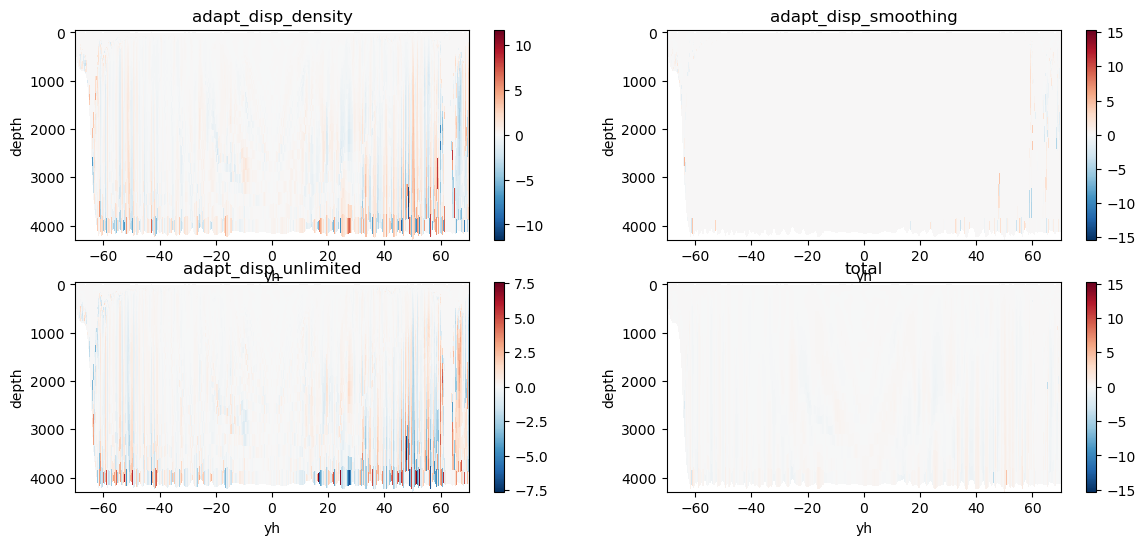

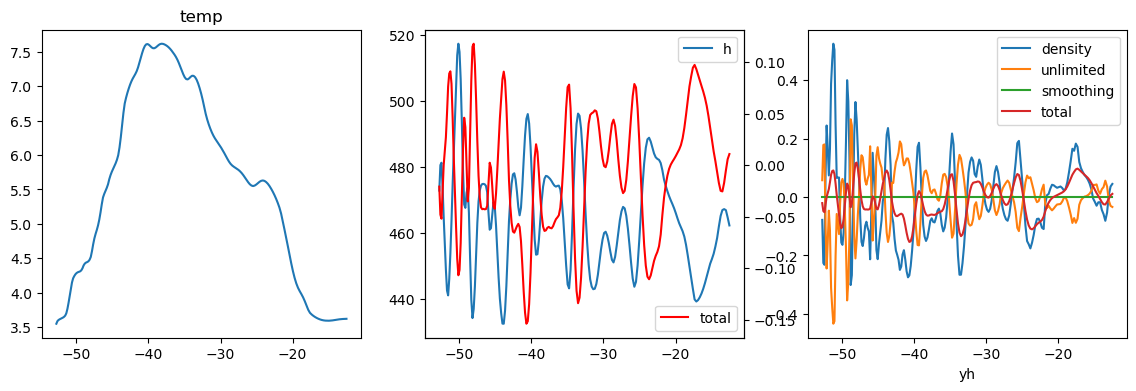

In [19]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Double minimum smoothing')

diagplot(diags)

## Without smooth_min, but reducing slope cutoff to compensate.

In [20]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_SMOOTH_MIN"] = 0.0                      # default is 0.1
params["ADAPT_SLOPE_CUTOFF"] = 0.002                 # default is 0.01
cs = pyale.mom_init_cs(params); 

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [21]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [22]:
state_sm0_sc0 = pyale.accelerate_ale(cs, adapt_cs, iter=500, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

h=state_sm0_sc0[0]
temp=state_sm0_sc0[1]
salt=state_sm0_sc0[2]
diags = state_sm0_sc0[3]


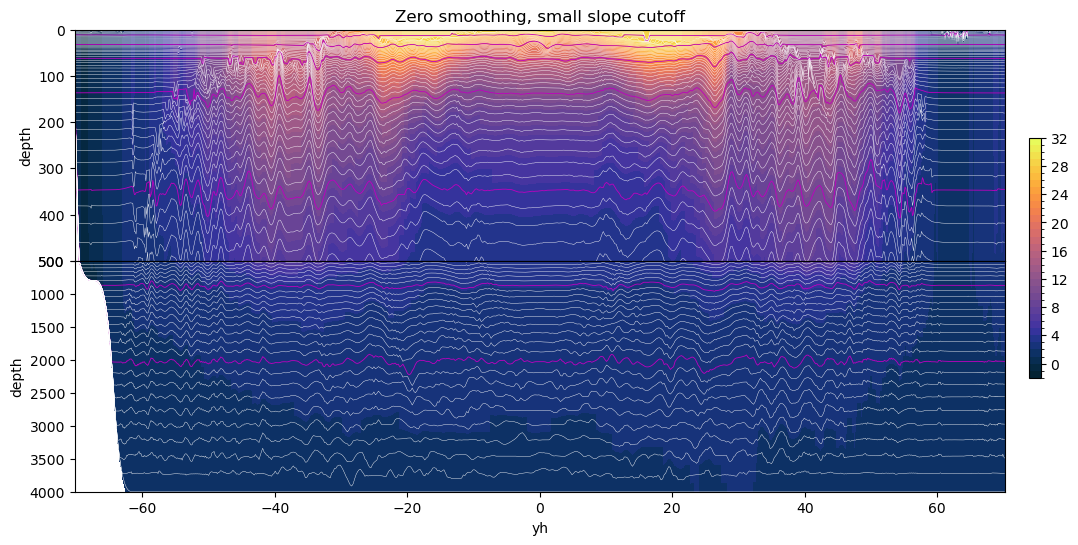

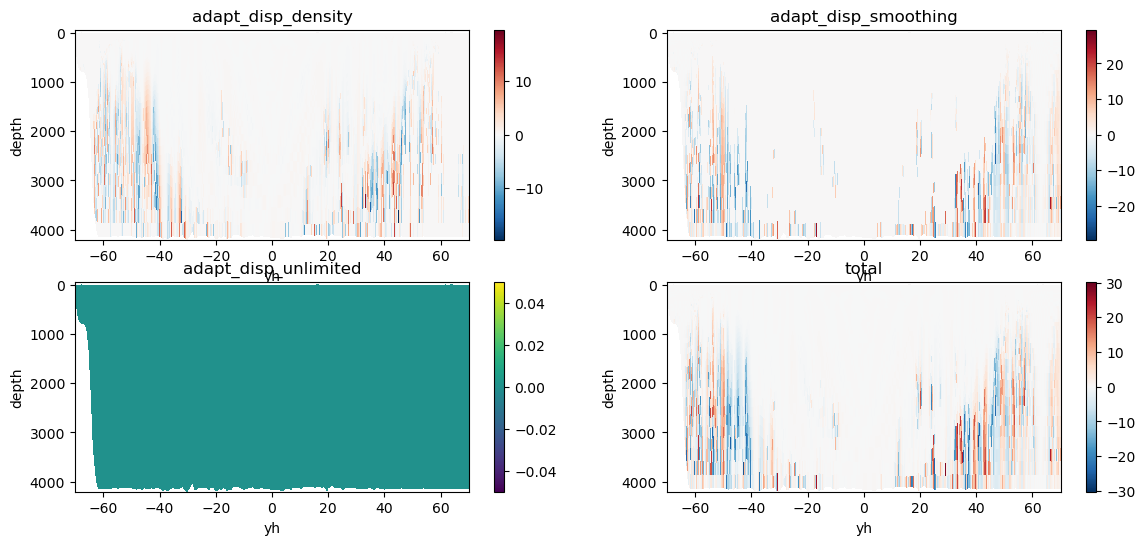

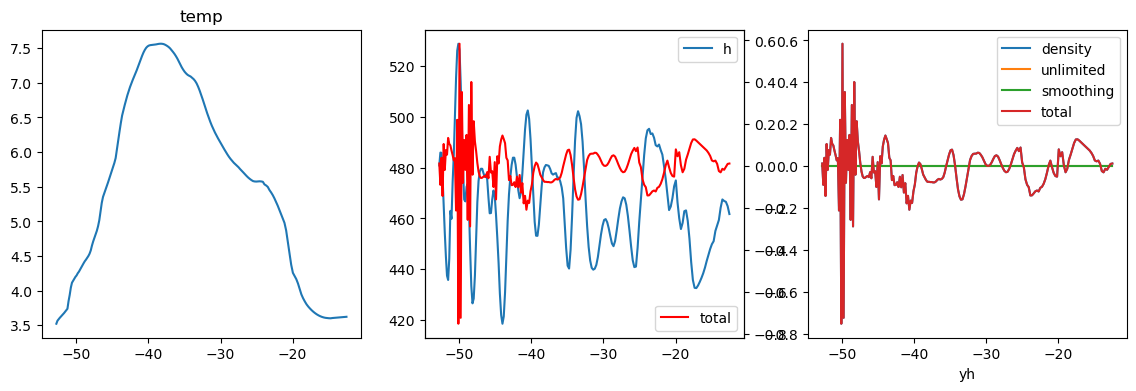

In [23]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Zero smoothing, small slope cutoff')

diagplot(diags)

## Trying a small min smoothing, and small slope cutoff

In [91]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
params["ADAPT_SMOOTH_MIN"] = 0.02                      # default is 0.1
params["ADAPT_SLOPE_CUTOFF"] = 0.002                 # default is 0.01
cs = pyale.mom_init_cs(params);

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [92]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

In [ ]:
state_sm0_sc02 = pyale.accelerate_ale(cs, adapt_cs, iter=500, dt=3600,diags=["adapt_disp_density","adapt_disp_smoothing","adapt_disp_unlimited"])

In [94]:
h=state_sm0_sc02[0]
temp=state_sm0_sc02[1]
salt=state_sm0_sc02[2]
diags = state_sm0_sc02[3]

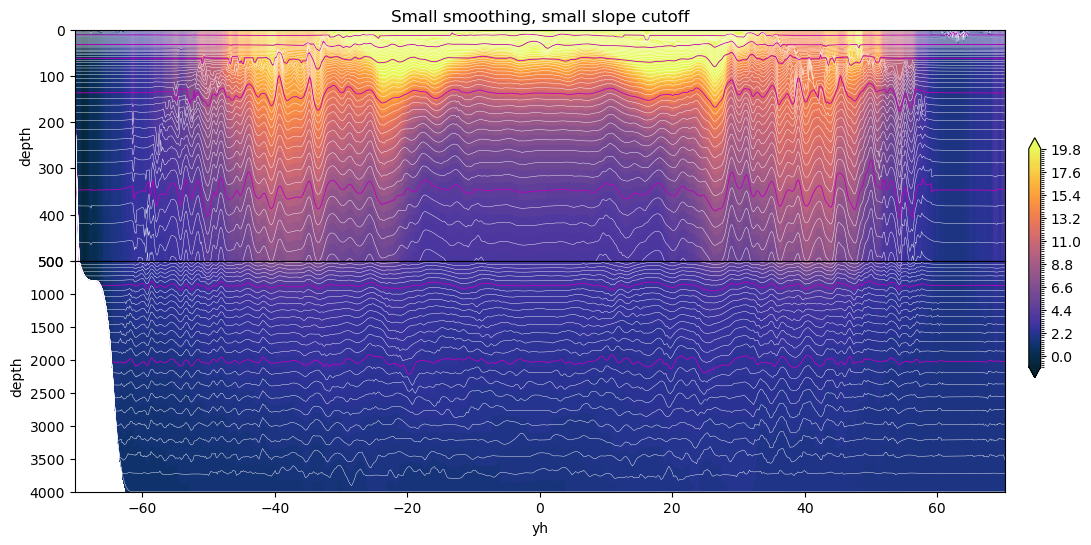

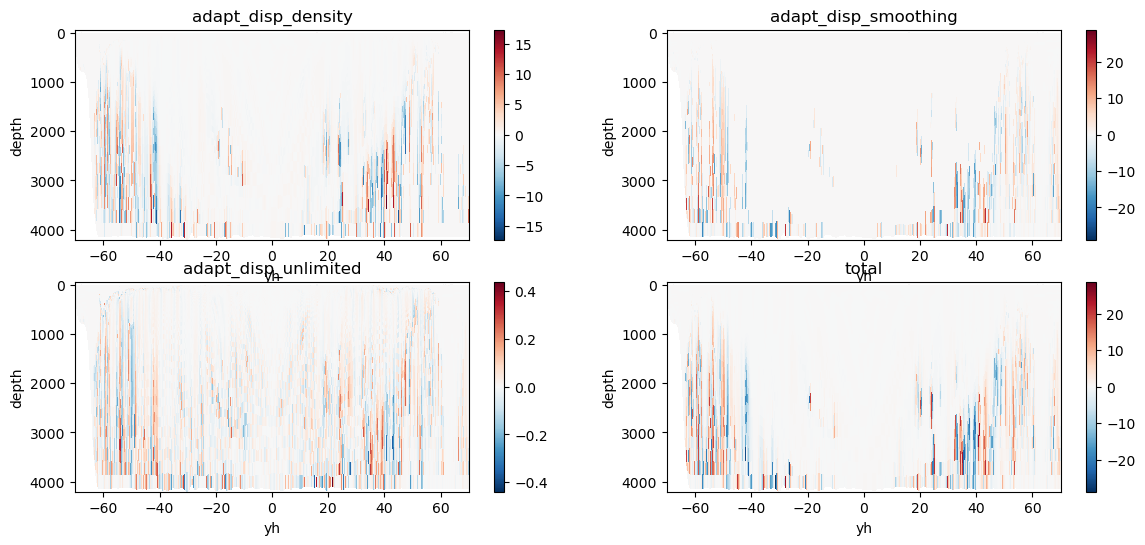

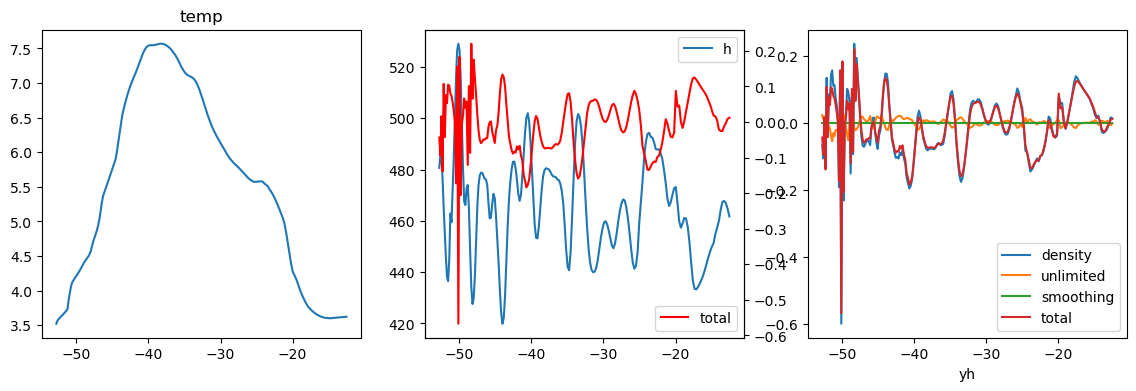

In [95]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))        
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Small smoothing, small slope cutoff')

diagplot(diags)

## making some proper plots

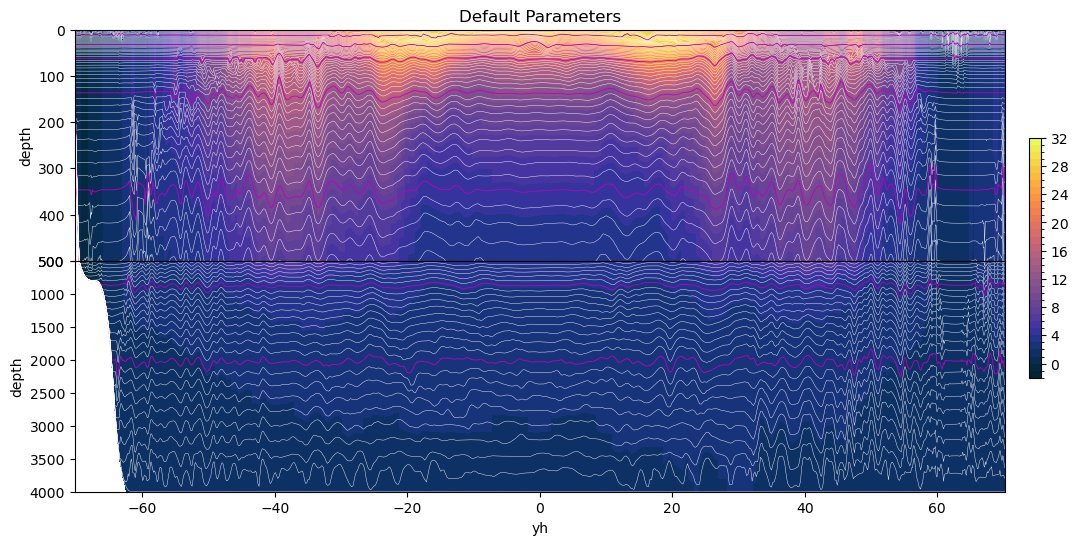

In [24]:
h=state_def[0]
temp=state_def[1]
salt=state_def[2]
diags = state_def[3]
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Default Parameters')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/default-params.png',dpi=300)

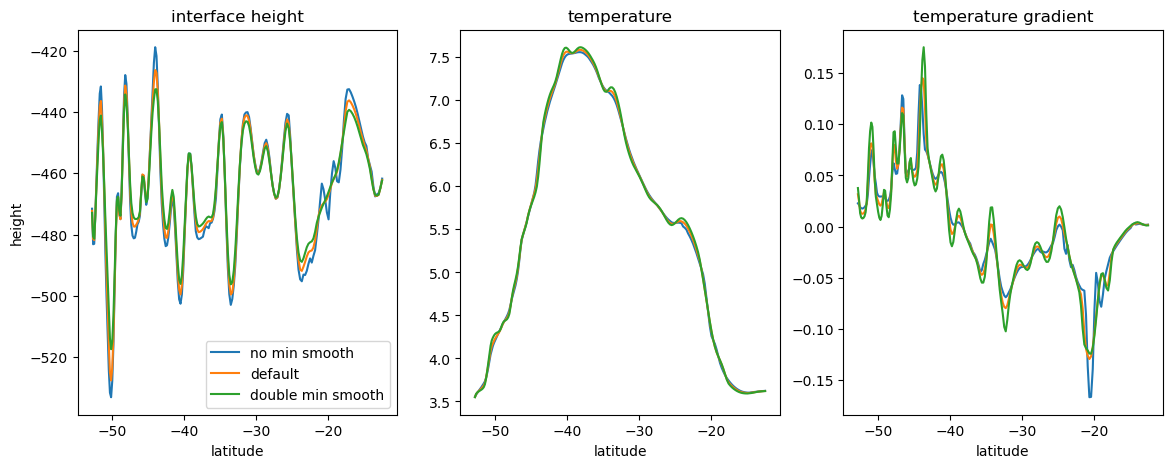

In [100]:
plt.figure(figsize=(14,5))
rvec = [150,350]
yh = ds2.lath.values[rvec[0]:rvec[1]]

## Interface height
plt.subplot(131)
h=state_sm0[0]
h_depth = np.cumsum(h[39,:,:],1)
plt.plot(yh,-h_depth[rvec[0]:rvec[1],48],label='no min smooth')
h=state_def[0]
h_depth = np.cumsum(h[39,:,:],1)
plt.plot(yh,-h_depth[rvec[0]:rvec[1],48],label='default')
h=state_sm2[0]
h_depth = np.cumsum(h[39,:,:],1)
plt.plot(yh,-h_depth[rvec[0]:rvec[1],48],label='double min smooth')
#h=state_sm0_sc0[0]
#h_depth = np.cumsum(h[39,:,:],1)
#plt.plot(yh,-h_depth[rvec[0]:rvec[1],48],label='no min smooth, low slope')
plt.legend()
plt.ylabel('height')
plt.xlabel('latitude')
plt.title('interface height')


## Temperature
plt.subplot(132)
temp=state_sm0[1]
plt.plot(yh,temp[39,rvec[0]:rvec[1],48])
temp=state_def[1]
plt.plot(yh,temp[39,rvec[0]:rvec[1],48])
temp=state_sm2[1]
plt.plot(yh,temp[39,rvec[0]:rvec[1],48])
#temp=state_sm0_sc0[1]
#plt.plot(yh,temp[39,rvec[0]:rvec[1],48])
plt.title('temperature')
plt.xlabel('latitude')

## Temperature
plt.subplot(133)
temp=state_sm0[1]
plt.plot(yh,np.gradient(temp[39,rvec[0]:rvec[1],48]))
temp=state_def[1]
plt.plot(yh,np.gradient(temp[39,rvec[0]:rvec[1],48]))
temp=state_sm2[1]
plt.plot(yh,np.gradient(temp[39,rvec[0]:rvec[1],48]))
#temp=state_sm0_sc0[1]
#plt.plot(yh,np.gradient(temp[39,rvec[0]:rvec[1],48]))
plt.title('temperature gradient')
plt.xlabel('latitude')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/smoothing.png',dpi=300)

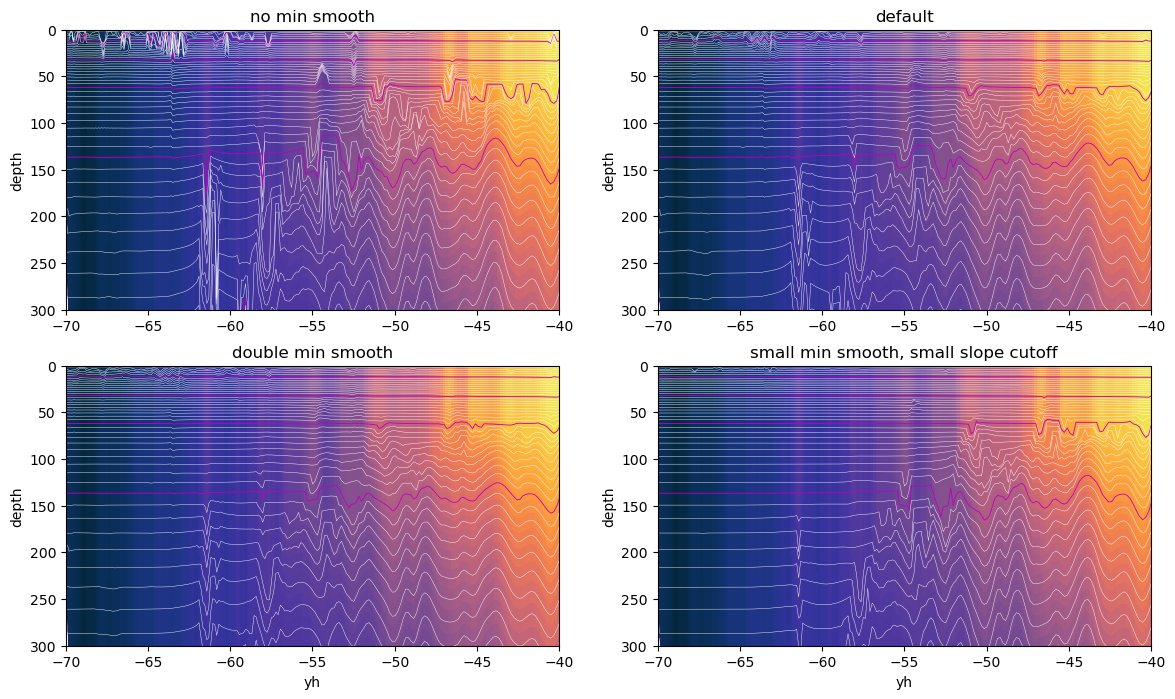

In [97]:
plt.figure(figsize=(14,8))
vlev=np.arange(-1,20,.2)
cmap=cm.cm.thermal

plt.subplot(221)
h=state_sm0[0]
temp=state_sm0[1]
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,300])
plt.xlim([-70,-40])
plt.gca().invert_yaxis()
plt.title('no min smooth')
plt.xlabel('')


plt.subplot(222)
h=state_def[0]
temp=state_def[1]
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,300])
plt.xlim([-70,-40])
plt.gca().invert_yaxis()
plt.title('default')
plt.xlabel('')


plt.subplot(223)
h=state_sm2[0]
temp=state_sm2[1]
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,300])
plt.xlim([-70,-40])
plt.gca().invert_yaxis()
plt.title('double min smooth')


plt.subplot(224)
h=state_sm0_sc02[0]
temp=state_sm0_sc02[1]
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
                coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth)))) 
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(new_temp.yh.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,300])
plt.xlim([-70,-40])
plt.gca().invert_yaxis()
plt.title('small min smooth, small slope cutoff')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/smooth_v_cutoff.png',dpi=300)

In [75]:
vlev


array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [82]:
np.arange(-1,10,.2)

array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
       -2.00000000e-01, -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,
        6.00000000e-01,  8.00000000e-01,  1.00000000e+00,  1.20000000e+00,
        1.40000000e+00,  1.60000000e+00,  1.80000000e+00,  2.00000000e+00,
        2.20000000e+00,  2.40000000e+00,  2.60000000e+00,  2.80000000e+00,
        3.00000000e+00,  3.20000000e+00,  3.40000000e+00,  3.60000000e+00,
        3.80000000e+00,  4.00000000e+00,  4.20000000e+00,  4.40000000e+00,
        4.60000000e+00,  4.80000000e+00,  5.00000000e+00,  5.20000000e+00,
        5.40000000e+00,  5.60000000e+00,  5.80000000e+00,  6.00000000e+00,
        6.20000000e+00,  6.40000000e+00,  6.60000000e+00,  6.80000000e+00,
        7.00000000e+00,  7.20000000e+00,  7.40000000e+00,  7.60000000e+00,
        7.80000000e+00,  8.00000000e+00,  8.20000000e+00,  8.40000000e+00,
        8.60000000e+00,  8.80000000e+00,  9.00000000e+00,  9.20000000e+00,
        9.40000000e+00,  